In [17]:
#
# Calibrate StrepA ABM with LFIRE using simulation-step indices 

import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")  # headless

import elfi
import pylfire
from numpy.random import default_rng, SeedSequence
from numpy.random import Generator as _NpGen, RandomState as _RS

from pylfire.classifiers.classifier import Classifier
from sklearn.linear_model import LogisticRegressionCV

# === Your ABM utilities (the Python ports you pasted earlier) ===
# Must define: initialise_agents(params), simulator(...), parameters(...), div(...)
import functions_list

In [18]:
# 0) Fixed hyperparameters (order MUST match functions_list.parameters())
# parameters(): [DurationSimulation, Nstrains, Dimmunity, sigma, omega, x,
#                Cperweek, Nagents, alpha, AgeDeath, BasicReproductionNumber]
# ----------------------------
DurationSimulation = 20.0       # years
Nstrains = 42
Dimmunity = 0.5 * 52.14         # weeks
omega = 0.1
x = 10.0
Cperweek = 34.53
Nagents = 2500
alpha = 3.0
AgeDeath = 71.0

In [19]:
# ----------------------------
# 1) Observations: treat these as SIMULATION STEP INDICES directly
#    (no conversions). Any index outside the simulated range is dropped.
# ----------------------------
time_obs_idx = np.array([
    1, 32, 62, 93, 123, 154, 185, 214, 245, 275,
    306, 336, 367, 398, 428, 459, 489, 520, 551, 579,
    610, 640, 671
], dtype=int)

time_obs_idx = time_obs_idx[time_obs_idx > 0] + 365*18  # skip the former 18 years

y_obs_full = np.array([
    0.074074074, 0.0, 0.0, 0.117647059, 0.055555556,
    0.014492754, 0.081967213, 0.087248322, 0.069767442, 0.058823529,
    0.028169014, 0.047619048, 0.05, 0.10880829, 0.076502732,
    0.071090047, 0.121052632, 0.06043956, 0.08040201, 0.046153846,
    0.09947644, 0.10106383, 0.043478261
], dtype=float)
assert time_obs_idx.size == y_obs_full.size, "time_obs and y_obs lengths differ"


In [20]:
# ----------------------------
# 2) Priors for (BasicReproductionNumber R0, sigma)
# ----------------------------
R0_LOW,  R0_HIGH  = 0.0, 5.0
SIG_LOW, SIG_HIGH = 0.5, 1.0

In [21]:
# ----------------------------
# 3) Build ABM param vector (theta = [R0, sigma])
# ----------------------------
def build_params(theta2):
    th = np.asarray(theta2, float).ravel()
    if th.size < 2:
        raise ValueError(f"theta2 must be length-2, got {np.shape(theta2)}")
    R0, sigma = float(th[0]), float(th[1])
    return np.array([
        DurationSimulation, Nstrains, Dimmunity, sigma, omega, x,
        Cperweek, Nagents, alpha, AgeDeath, R0
    ], dtype=float)

In [22]:
# ----------------------------
# 4) One ABM run → full prevalence series (length T)
# ----------------------------
def simulate_prevalence(theta2, rng):
    # Seed global RNG because ABM uses np.random internally
    np.random.seed(int(rng.integers(0, 2**32 - 1)))
    params = build_params(theta2)
    AC, IMM, _ = functions_list.initialise_agents(params)
    SSPrev, AIBKS = functions_list.simulator_v3_numba(AC, IMM, params, 0, 1)
    prevalence = SSPrev.sum(axis=0) / Nagents   # shape (T,)
    return np.asarray(prevalence, float)

In [23]:
# ----------------------------
# 5) Filter indices to those available from the simulator; align y_obs
# ----------------------------
# Dry run to learn T
_Tdry = simulate_prevalence(np.array([2.0, 1.0], float), default_rng(0))
T = _Tdry.size
print("T's size", T)

T's size 7300


In [24]:
idx = time_obs_idx.astype(int)
print("time_obse_index: ", idx)
valid = (idx >= 0) & (idx < T)
print("valid:", valid)
idx_valid = idx[valid]
print("idx_valid:", idx)
y_obs = y_obs_full[valid]
print("y_obs:", y_obs)
print(f"[INFO] Using {idx_valid.size}/{idx.size} observed points within simulation range; T={T}")


time_obse_index:  [6571 6602 6632 6663 6693 6724 6755 6784 6815 6845 6876 6906 6937 6968
 6998 7029 7059 7090 7121 7149 7180 7210 7241]
valid: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
idx_valid: [6571 6602 6632 6663 6693 6724 6755 6784 6815 6845 6876 6906 6937 6968
 6998 7029 7059 7090 7121 7149 7180 7210 7241]
y_obs: [0.07407407 0.         0.         0.11764706 0.05555556 0.01449275
 0.08196721 0.08724832 0.06976744 0.05882353 0.02816901 0.04761905
 0.05       0.10880829 0.07650273 0.07109005 0.12105263 0.06043956
 0.08040201 0.04615385 0.09947644 0.10106383 0.04347826]
[INFO] Using 23/23 observed points within simulation range; T=7300


In [25]:
# ----------------------------
# 6) Summary function on the selected values
# ----------------------------
def my_summary(series_1d):
    y = np.asarray(series_1d, float).ravel()
    n = y.size
    if n == 0:
        return np.array([np.nan, np.nan, np.nan, np.nan, 0.0], float)
    auc   = float(np.trapz(y))
    peak  = float(np.max(y))
    tpk   = float(np.argmax(y) / max(n, 1))   # relative peak time
    last  = float(y[-1])
    rough = float(np.sum(np.diff(y)**2)) if n > 1 else 0.0
    return np.array([auc, peak, tpk, last, rough], float)


In [26]:

s_obs = my_summary(y_obs)
print("s_obs", s_obs)

s_obs [1.43505549 0.12105263 0.69565217 0.04347826 0.04963394]


In [27]:
# ----------------------------
# 7) Robust ELFI random_state → int seed
# ----------------------------
def _seed_from_random_state(random_state):
    if isinstance(random_state, _NpGen):
        return int(random_state.integers(0, 2**32 - 1))
    if isinstance(random_state, _RS):
        return int(random_state.randint(0, 2**32 - 1))
    if isinstance(random_state, (int, np.integer)):
        return int(random_state)
    return int(np.random.randint(0, 2**32 - 1))

In [28]:
# ----------------------------
# 8) ELFI simulator: return simulated values at YOUR indices (idx_valid)
# ----------------------------
def elfi_simulator(R0, sigma, batch_size=1, random_state=None):
    R0    = np.atleast_1d(np.asarray(R0, float))
    sigma = np.atleast_1d(np.asarray(sigma, float))
    bs = int(max(R0.size, sigma.size, int(batch_size)))
    if R0.size == 1:    R0    = np.repeat(R0, bs)
    if sigma.size == 1: sigma = np.repeat(sigma, bs)

    seed = _seed_from_random_state(random_state)
    ss_parent = SeedSequence(seed)
    gens = [default_rng(s) for s in ss_parent.spawn(bs)]

    outs = []
    for i in range(bs):
        theta_i = np.array([R0[i], sigma[i]], float)
        prev_i = simulate_prevalence(theta_i, gens[i])  # full series (length T)
        outs.append(prev_i[idx_valid])                  # pick your indices only
    return np.stack(outs, axis=0)                       # (bs, len(idx_valid))

In [29]:
# ----------------------------
# 9) Build ELFI graph (no context manager)
# ----------------------------
m = elfi.new_model()
R0_node  = elfi.Prior('uniform', R0_LOW,  R0_HIGH  - R0_LOW,  model=m, name='R0')
SIG_node = elfi.Prior('uniform', SIG_LOW, SIG_HIGH - SIG_LOW, model=m, name='sigma')
sim_node = elfi.Simulator(elfi_simulator, R0_node, SIG_node, model=m, name='sim')
summary_node = elfi.Summary(my_summary, sim_node, observed=s_obs, model=m, name='summary')


In [30]:

# ----------------------------
# 10) Build LFIRE classifier
# ----------------------------
class SKLogitClassifierAdapter(Classifier):
    parallel_cv = False  # tell PYLFIRE not to parallelize via ELFI client

    def __init__(self, cv=5, n_jobs=1, max_iter=2000):
        # do NOT call super().__init__()
        self.cv = int(cv)
        self.n_jobs = None if int(n_jobs) == 1 else int(n_jobs)
        self.max_iter = int(max_iter)
        self.models_ = {}

    def fit(self, X, y, index=0):
        X = np.asarray(X, float)
        y = np.asarray(y)

        # Ensure 2D features
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Map {-1,+1} -> {0,1} if needed
        uniq = np.unique(y)
        if set(uniq.tolist()) == {-1, 1}:
            y = ((y + 1) // 2).astype(int)

        # Effective CV ≤ samples per class (min 2)
        n_pos = int((y == 1).sum())
        n_neg = int((y == 0).sum())
        cv_eff = max(2, min(self.cv, n_pos, n_neg))

        lr = LogisticRegressionCV(
            cv=cv_eff, max_iter=self.max_iter, solver="lbfgs",
            scoring="neg_log_loss", n_jobs=self.n_jobs
        )
        lr.fit(X, y)
        self.models_[index] = lr
        return self

    def predict_likelihood_ratio(self, obs, index=0):
        lr = self.models_[index]
        obs = np.asarray(obs, float).ravel()

        # Match feature count used in fit
        n_feat = int(getattr(lr, "n_features_in_", obs.size))
        if obs.size != n_feat:
            if obs.size > n_feat:
                obs = obs[:n_feat]
            else:
                obs = np.pad(obs, (0, n_feat - obs.size), mode="constant", constant_values=0.0)

        obs = obs.reshape(1, -1)
        proba = lr.predict_proba(obs)[0]
        classes = lr.classes_
        pos_idx = int(np.where(classes == 1)[0][0]) if 1 in classes else 1
        p1 = float(proba[pos_idx])
        p0 = max(1e-12, 1.0 - p1)
        return p1 / p0


In [31]:
# ----------------------------
# 11) Parameter grid for LFIRE
# ----------------------------
FAST = 1
# ---- fast settings ----
if FAST:
    Nstrains = 42                # (was 42)
    Nagents = 2500               # (was 2500)
    # tiny LFIRE grid
    R0_grid  = np.linspace(R0_LOW,  R0_HIGH,  5)
    SIG_grid = np.linspace(SIG_LOW, SIG_HIGH, 4)
    batch_size_lfire = 32       # (was 512)
else:
    # original grid / batch size
    R0_grid  = np.linspace(R0_LOW,  R0_HIGH,  40)
    SIG_grid = np.linspace(SIG_LOW, SIG_HIGH, 20)
    batch_size_lfire = 64

TT1, TT2 = np.meshgrid(R0_grid, SIG_grid, indexing='ij')
params_grid = np.c_[TT1.ravel(), TT2.ravel()]  # (40*20, 2)

In [32]:
# ----------------------------
# 12) Run LFIRE
# ----------------------------
clf = SKLogitClassifierAdapter(cv=5, max_iter=2000)

# lfire = pylfire.LFIRE(
#     model=m,
#     params_grid=params_grid,
#     batch_size=batch_size_lfire,
#     classifier=clf,
#     output_names=['summary', 'R0', 'sigma']  # <-- add params here
# )

lfire = pylfire.LFIRE(
    model=m,
    params_grid=params_grid,
    batch_size=batch_size_lfire,
    classifier=clf,
    output_names=['summary', 'R0', 'sigma']  # <-- add params here
)
print("xxx")
res = lfire.infer()

xxx
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [33]:
# ----------------------------
# 13) Save posterior results
# ----------------------------
def extract_posterior_any(res, lfire_obj, params_grid):
    """Robustly pull (theta_grid, weights) from PYLFIRE/ELFI results."""
    theta, w = None, None

    # 1) Try dict-like/attr-like result first
    if isinstance(res, dict):
        theta = res.get("theta") or res.get("thetas") or res.get("grid")
        w = res.get("posterior") or res.get("weights") or res.get("post")
    else:
        theta = getattr(res, "theta", None)
        w = (getattr(res, "posterior", None)
             or getattr(res, "weights", None)
             or getattr(res, "post", None)
             or (getattr(res, "results", {}).get("weights") if hasattr(res, "results") else None))

    # 2) Pull from lfire.state (most reliable path)
    if (theta is None or w is None) and hasattr(lfire_obj, "state"):
        st = lfire_obj.state
        # get parameter names and stack their tracked values into a grid
        names = getattr(lfire_obj, "parameter_names", None)
        if not names:
            names = [k for k in ("R0", "sigma") if k in st]  # sensible default
        cols = []
        for nm in names:
            if nm in st:
                cols.append(np.asarray(st[nm]).ravel())
        if cols and all(c.size == cols[0].size for c in cols):
            theta = np.column_stack(cols)
        # posterior array is usually here
        w = st.get("posterior", w)

    # 3) As a last resort, evaluate posterior now (may be unnecessary)
    if (w is None) and hasattr(lfire_obj, "_evaluate_posterior"):
        try:
            ev = lfire_obj._evaluate_posterior()
            if isinstance(ev, dict):
                w = ev.get("posterior") or ev.get("weights") or ev.get("post")
            if theta is None:
                theta = params_grid
        except Exception:
            pass

    # 4) Final fallbacks
    if theta is None:
        theta = params_grid
    theta = np.asarray(theta, float)

    if w is None:
        # uniform fallback if classifier produced degenerate/hidden weights
        w = np.ones(theta.shape[0], float)
    else:
        w = np.asarray(w, float).ravel()

    # clean + normalise
    w = np.clip(w, 0, None)
    s = np.nansum(w)
    w = (np.ones_like(w) / max(w.size, 1)) if (not np.isfinite(s) or s <= 0) else (w / s)
    return theta, w

# use it
theta_grid, weights = extract_posterior_any(res, lfire_obj=lfire, params_grid=params_grid)

map_idx    = int(np.argmax(weights))
theta_map  = theta_grid[map_idx]
theta_mean = (weights[:, None] * theta_grid).sum(axis=0)

print(f"[RESULT] MAP: {theta_map} | Posterior mean: {theta_mean}")

import os, pandas as pd
os.makedirs("experimental_data", exist_ok=True)
pd.DataFrame(theta_grid, columns=["R0", "sigma"]).assign(weight=weights)\
  .to_csv("experimental_data/posterior_grid.csv", index=False)
print("Saved → experimental_data/posterior_grid.csv")


[RESULT] MAP: [1.25       0.83333333] | Posterior mean: [2.26341792 0.75321281]
Saved → experimental_data/posterior_grid.csv


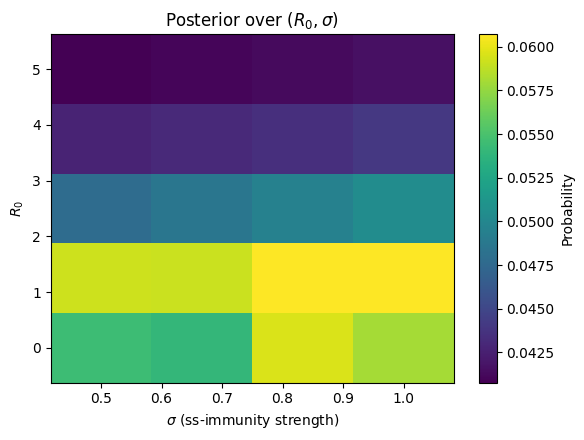

Saved → experimental_data/posterior_heatmap.png


In [41]:
# ----------------------------
#  Heatmap 
# ----------------------------

# Get θ-grid and normalized weights
theta_grid = np.column_stack([np.asarray(lfire.state['R0']).ravel(),
                              np.asarray(lfire.state['sigma']).ravel()])
w = np.asarray(lfire.state.get('posterior'), float).ravel()
w = np.clip(w, 0, None); w = w / (w.sum() if w.sum() > 0 else 1.0)

%matplotlib inline

# or, in pure Python:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')

import matplotlib.pyplot as plt
R0_vals  = np.unique(theta_grid[:,0])
SIG_vals = np.unique(theta_grid[:,1])

# reshape to 2D if grid is rectangular
if R0_vals.size * SIG_vals.size == theta_grid.shape[0]:
    post2d = w.reshape(R0_vals.size, SIG_vals.size, order='C')  # 'ij' meshgrid
    plt.figure(figsize=(6,4.5))
    plt.pcolormesh(SIG_vals, R0_vals, post2d, shading='auto')
    plt.xlabel(r'$\sigma$ (ss-immunity strength)')
    plt.ylabel(r'$R_0$')
    plt.title('Posterior over $(R_0, \sigma)$')
    plt.colorbar(label='Probability')
    plt.tight_layout()
    plt.savefig('experimental_data/posterior_heatmap.png', dpi=160)
    plt.show()
    plt.close()
    print("Saved → experimental_data/posterior_heatmap.png")

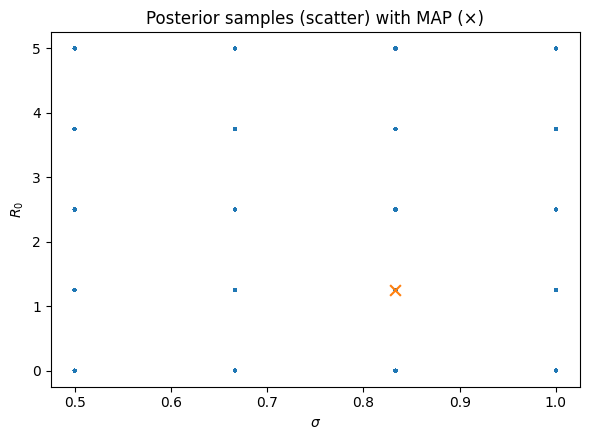

Saved → experimental_data/posterior_scatter.png


In [35]:
# ----------------------------
#  draw samples from the discrete posterior
# ----------------------------
# 
rng = np.random.default_rng(0)
idx = rng.choice(theta_grid.shape[0], size=5000, replace=True, p=w)
samps = theta_grid[idx]
R0_s, SIG_s = samps[:,0], samps[:,1]

# MAP point
map_idx = int(np.argmax(w))
theta_map = theta_grid[map_idx]

plt.figure(figsize=(6,4.5))
plt.scatter(SIG_s, R0_s, s=6, alpha=0.25, edgecolors='none')
plt.scatter([theta_map[1]],[theta_map[0]], s=60, marker='x')
plt.xlabel(r'$\sigma$'); plt.ylabel(r'$R_0$'); plt.title('Posterior samples (scatter) with MAP (×)')
plt.tight_layout()
plt.savefig('experimental_data/posterior_scatter.png', dpi=160)
plt.show()
plt.close()
print("Saved → experimental_data/posterior_scatter.png")

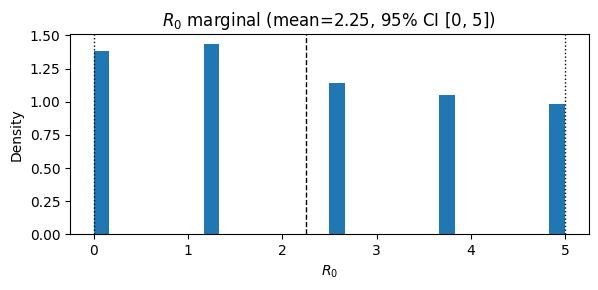

Saved → experimental_data/posterior_marginal_R0.png


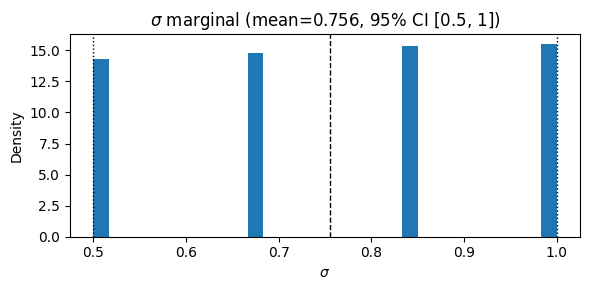

Saved → experimental_data/posterior_marginal_sigma.png


In [36]:
# ----------------------------
#  Marginal densities + 95% CIs
# ----------------------------
# 
def ci95(a): 
    lo, hi = np.quantile(a, [0.025, 0.975]); return float(lo), float(hi)

lo_R0, hi_R0   = ci95(R0_s)
lo_SIG, hi_SIG = ci95(SIG_s)
mean_R0  = float(R0_s.mean())
mean_SIG = float(SIG_s.mean())

# R0
plt.figure(figsize=(6,3))
plt.hist(R0_s, bins=30, density=True)
plt.axvline(mean_R0, color='k', linestyle='--', linewidth=1)
plt.axvline(lo_R0,  color='k', linestyle=':',  linewidth=1)
plt.axvline(hi_R0,  color='k', linestyle=':',  linewidth=1)
plt.title(rf'$R_0$ marginal (mean={mean_R0:.3g}, 95% CI [{lo_R0:.3g}, {hi_R0:.3g}])')
plt.xlabel(r'$R_0$'); plt.ylabel('Density'); plt.tight_layout()
plt.savefig('experimental_data/posterior_marginal_R0.png', dpi=160)
plt.show()
plt.close()
print("Saved → experimental_data/posterior_marginal_R0.png")

# sigma
plt.figure(figsize=(6,3))
plt.hist(SIG_s, bins=30, density=True)
plt.axvline(mean_SIG, color='k', linestyle='--', linewidth=1)
plt.axvline(lo_SIG,  color='k', linestyle=':',  linewidth=1)
plt.axvline(hi_SIG,  color='k', linestyle=':',  linewidth=1)
plt.title(rf'$\sigma$ marginal (mean={mean_SIG:.3g}, 95% CI [{lo_SIG:.3g}, {hi_SIG:.3g}])')
plt.xlabel(r'$\sigma$'); plt.ylabel('Density'); plt.tight_layout()
plt.savefig('experimental_data/posterior_marginal_sigma.png', dpi=160)
plt.show()
plt.close()
print("Saved → experimental_data/posterior_marginal_sigma.png")

In [37]:
# ----------------------------
#  Get posterior over parameters (θ = [R0, σ])
# ----------------------------
# 
import numpy as np

# θ-grid from LFIRE’s state
theta_grid = np.column_stack([
    np.asarray(lfire.state['R0']).ravel(),
    np.asarray(lfire.state['sigma']).ravel()
])

# posterior weights (normalize)
w = np.asarray(lfire.state.get('posterior'), float).ravel()
w = np.clip(w, 0, None)
w = w / (w.sum() if w.sum() > 0 else 1.0)

# point estimates
i_map     = int(np.argmax(w))
theta_map = theta_grid[i_map]
theta_mean= (w[:, None] * theta_grid).sum(axis=0)

print(f"MAP:   R0={theta_map[0]:.3f}, sigma={theta_map[1]:.3f}")
print(f"Mean:  R0={theta_mean[0]:.3f}, sigma={theta_mean[1]:.3f}")

MAP:   R0=1.250, sigma=0.833
Mean:  R0=2.263, sigma=0.753


In [38]:
# Generate fitted curves (MAP & posterior predictive) 
from numpy.random import default_rng

rng = default_rng(0)

# helper: simulate & select your time indices
def sim_at(theta_2, seed=None):
    g = default_rng(seed) if seed is not None else rng
    full = simulate_prevalence(np.asarray(theta_2, float), g)
    return full[idx_valid]   # <- your selected indices only

# MAP fit
y_hat_map = sim_at(theta_map, seed=123)

# Posterior predictive: sample θ from grid according to w, simulate many times
n_ppc = 500   # increase later for smoother bands
idxs = rng.choice(theta_grid.shape[0], size=n_ppc, replace=True, p=w)
ppc  = np.stack([sim_at(theta_grid[i], seed=int(rng.integers(0, 2**32-1)))
                 for i in idxs], axis=0)    # shape (n_ppc, L)
y_hat_mean = ppc.mean(axis=0)
lo, hi     = np.quantile(ppc, [0.025, 0.975], axis=0)  # 95% band

In [45]:
# Error metrics (raw points & summary)

def rmsd(a, b):
    a = np.asarray(a,float); b = np.asarray(b,float)
    return np.sqrt(np.mean((a-b)**2))

def mape(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true,float)
    y_pred = np.asarray(y_pred,float)
    denom = np.where(np.abs(y_true) < eps, np.nan, y_true)
    return np.nanmean(np.abs((y_pred - y_true)/denom)) * 100.0

# pointwise fit metrics
# print(y_obs_full)
# print(y_obs)
rmsd_map  = rmsd(y_obs_full, y_hat_map)
mape_map  = mape(y_obs_full, y_hat_map)
rmsd_mean = rmsd(y_obs_full, y_hat_mean)
mape_mean = mape(y_obs_full, y_hat_mean)

# summary-space metrics (optional)
s_obs     = my_summary(y_obs_full)
s_map     = my_summary(y_hat_map)
s_mean    = my_summary(y_hat_mean)
rmsd_sum_map  = rmsd(s_obs, s_map)
rmsd_sum_mean = rmsd(s_obs, s_mean)

print(f"MAP fit:   RMSD={rmsd_map:.4g},  MAPE={mape_map:.3g}%  | summary RMSD={rmsd_sum_map:.4g}")
print(f"Mean fit:  RMSD={rmsd_mean:.4g}, MAPE={mape_mean:.3g}% | summary RMSD={rmsd_sum_mean:.4g}")


[0.07407407 0.         0.         0.11764706 0.05555556 0.01449275
 0.08196721 0.08724832 0.06976744 0.05882353 0.02816901 0.04761905
 0.05       0.10880829 0.07650273 0.07109005 0.12105263 0.06043956
 0.08040201 0.04615385 0.09947644 0.10106383 0.04347826]
[0.07407407 0.         0.         0.11764706 0.05555556 0.01449275
 0.08196721 0.08724832 0.06976744 0.05882353 0.02816901 0.04761905
 0.05       0.10880829 0.07650273 0.07109005 0.12105263 0.06043956
 0.08040201 0.04615385 0.09947644 0.10106383 0.04347826]
MAP fit:   RMSD=0.03606,  MAPE=49.4%  | summary RMSD=0.05046
Mean fit:  RMSD=0.8188, MAPE=1.49e+03% | summary RMSD=8.067


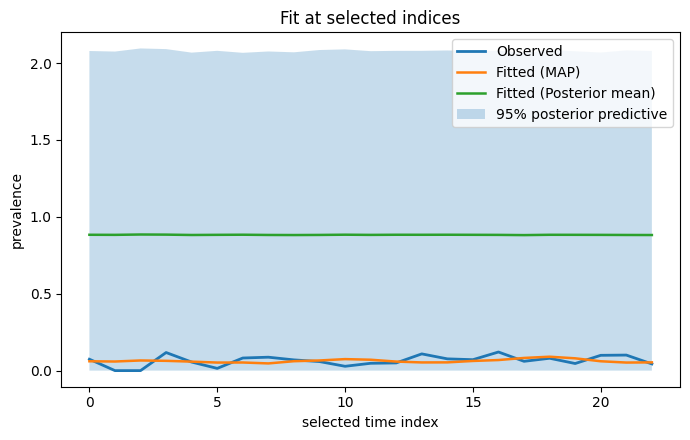

Saved → experimental_data/fit_at_selected_indices.png


In [40]:
# Plots: observed vs. fitted + 95% band

import matplotlib.pyplot as plt

x = np.arange(y_obs.size)  # just 0..L-1 (you can replace with your actual time ticks)

plt.figure(figsize=(7,4.5))
plt.plot(x, y_obs,      lw=2, label="Observed")
plt.plot(x, y_hat_map,  lw=1.8, label="Fitted (MAP)")
plt.plot(x, y_hat_mean, lw=1.8, label="Fitted (Posterior mean)")
plt.fill_between(x, lo, hi, alpha=0.25, label="95% posterior predictive")
plt.xlabel("selected time index")
plt.ylabel("prevalence")
plt.title("Fit at selected indices")
plt.legend()
plt.tight_layout()
plt.savefig('experimental_data/fit_at_selected_indices.png', dpi=160)
plt.show()
plt.close()
print("Saved → experimental_data/fit_at_selected_indices.png")